In [106]:
import os
import numpy as np
import glob
import PIL.Image as Image
import copy 
# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
# from time import time
import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [107]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

The code will run on GPU.


# Part 1

## Create dataset and dataloaders

In [108]:
data_path = '/dtu/datasets1/02514/isic/train_allstyles'
class ISIC(torch.utils.data.Dataset):
    def __init__(self, transform, train=False, test=False, data_path=data_path):
        'Initialization'
        self.transform = transform
        image_paths = os.listdir(os.path.join(data_path, 'Images'))
        label_paths = os.listdir(os.path.join(data_path, 'Segmentations'))

        if test:
            self.couples = []
            for image in image_paths:
                for label in label_paths:
                    if 'DS_' in image or 'DS_' in label: continue
                    if image[:12] in label:
                        self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)])

        else:
            self.couples = []
            counter = 0
            for image in image_paths:
                for label in label_paths:
                    if 'DS_' in image or 'DS_' in label: continue
                    if train:
                        if counter < len(image_paths)*0.8:
                            if image[:12] in label:
                                self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)])
                    else:
                        if counter >= len(image_paths)*0.8:
                            if image[:12] in label:
                                self.couples.append([os.path.join(data_path, 'Images', image), os.path.join(data_path, 'Segmentations', label)]) 
                counter += 1
                
        print(len(self.couples))

    def __len__(self):
        'Returns the total number of samples'
        return len(self.couples)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.couples[idx][0]
        label_path = self.couples[idx][1]
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        Y = self.transform(label)
        X = self.transform(image)
        return X, Y


In [109]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
trainset = ISIC(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
validationset = ISIC(train=False, transform=test_transform)
validation_loader = DataLoader(validationset, batch_size=batch_size, shuffle=True, num_workers=3)

240
60


### Visualization of annotations

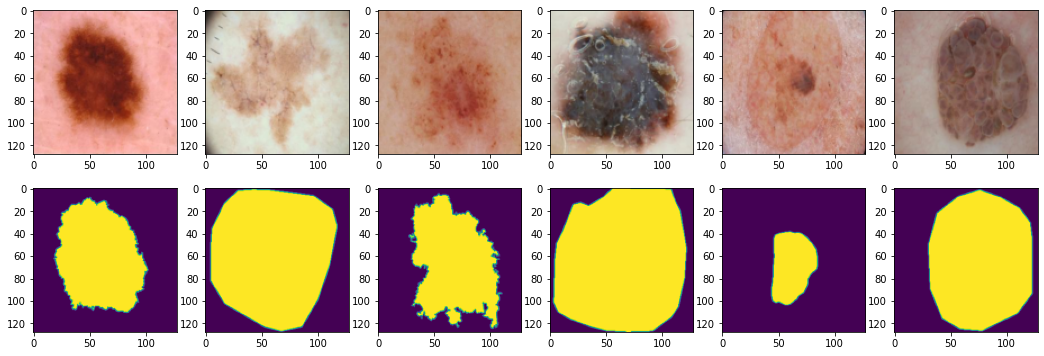

In [110]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

## UNet implementation

In [111]:
class UNet2(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(UNet2, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        self.num_channels = input_channels

        self.vgg16 = models.vgg16(pretrained=True)


        # Encoder layers

        self.encoder_conv_00 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=self.input_channels,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_01 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_02 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(64)
                                                ])
        self.encoder_conv_10 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=64,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_11 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_12 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(128)
                                                ])
        self.encoder_conv_20 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=128,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_21 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_22 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_23 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(256)
                                                ])
        self.encoder_conv_30 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=256,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_31 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_32 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_33 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_40 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_41 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_42 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)
                                                ])
        self.encoder_conv_43 = nn.Sequential(*[
                                                nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1,
                                                          stride=2),
                                                nn.BatchNorm2d(512)
                                                ])

        self.init_vgg_weigts()

        # Decoder layers

        self.decoder_convtr_43 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_42 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_41 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_40 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_33 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_32 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_31 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)
                                               ])
        self.decoder_convtr_30 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_23 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_22 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_21 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)
                                               ])
        self.decoder_convtr_20 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_12 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=128,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_11 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*128,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)
                                               ])
        self.decoder_convtr_10 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_02 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=64,
                                                                   kernel_size=4,
                                                                   padding=1,
                                                                   stride=2),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_01 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=2*64,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)
                                               ])
        self.decoder_convtr_00 = nn.Sequential(*[
                                                nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=self.output_channels,
                                                                   kernel_size=3,
                                                                   padding=1)
                                               ])


    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """

        # Encoder

        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = F.relu(self.encoder_conv_00(input_img))
        x_01 = F.relu(self.encoder_conv_01(x_00))
        x_02 = F.relu(self.encoder_conv_02(x_01))
        # x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_02.size()
        x_10 = F.relu(self.encoder_conv_10(x_02))
        x_11 = F.relu(self.encoder_conv_11(x_10))
        x_12 = F.relu(self.encoder_conv_12(x_11))
        # x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_12.size()
        x_20 = F.relu(self.encoder_conv_20(x_12))
        x_21 = F.relu(self.encoder_conv_21(x_20))
        x_22 = F.relu(self.encoder_conv_22(x_21))
        x_23 = F.relu(self.encoder_conv_23(x_22))
        # x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 4
        dim_3 = x_23.size()
        x_30 = F.relu(self.encoder_conv_30(x_23))
        x_31 = F.relu(self.encoder_conv_31(x_30))
        x_32 = F.relu(self.encoder_conv_32(x_31))
        x_33 = F.relu(self.encoder_conv_33(x_32))
        # x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 5
        dim_4 = x_33.size()
        x_40 = F.relu(self.encoder_conv_40(x_33))
        x_41 = F.relu(self.encoder_conv_41(x_40))
        x_42 = F.relu(self.encoder_conv_42(x_41))
        x_43 = F.relu(self.encoder_conv_43(x_42))
        # x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_43.size()

        # Decoder Stage - 5
        # x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_43d = F.relu(self.decoder_convtr_43(x_43))
        x_4d = torch.cat((x_43d, x_42), dim=1)
        x_42d = F.relu(self.decoder_convtr_42(x_4d))
        x_41d = F.relu(self.decoder_convtr_41(x_42d))
        x_40d = F.relu(self.decoder_convtr_40(x_41d))
        dim_4d = x_40d.size()

        # Decoder Stage - 4
        # x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_33d = F.relu(self.decoder_convtr_33(x_40d))
        x_3d = torch.cat((x_33d, x_32), dim=1)
        x_32d = F.relu(self.decoder_convtr_32(x_3d))
        x_31d = F.relu(self.decoder_convtr_31(x_32d))
        x_30d = F.relu(self.decoder_convtr_30(x_31d))
        dim_3d = x_30d.size()

        # Decoder Stage - 3
        # x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_23d = F.relu(self.decoder_convtr_23(x_30d))
        x_2d = torch.cat((x_23d, x_22), dim=1)
        x_22d = F.relu(self.decoder_convtr_22(x_2d))
        x_21d = F.relu(self.decoder_convtr_21(x_22d))
        x_20d = F.relu(self.decoder_convtr_20(x_21d))
        dim_2d = x_20d.size()

        # Decoder Stage - 2
        # x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_12d = F.relu(self.decoder_convtr_12(x_20d))
        x_1d = torch.cat((x_12d, x_11), dim=1)
        x_11d = F.relu(self.decoder_convtr_11(x_1d))
        x_10d = F.relu(self.decoder_convtr_10(x_11d))
        dim_1d = x_10d.size()

        # Decoder Stage - 1
        # x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_02d = F.relu(self.decoder_convtr_02(x_10d))
        x_0d = torch.cat((x_02d, x_01), dim=1)
        x_01d = F.relu(self.decoder_convtr_01(x_0d))
        x_00d = self.decoder_convtr_00(x_01d)
        dim_0d = x_00d.size()

        x_sigmoid = torch.sigmoid(x_00d)

        if DEBUG:
            print("dim_0: {}".format(dim_0))
            print("dim_1: {}".format(dim_1))
            print("dim_2: {}".format(dim_2))
            print("dim_3: {}".format(dim_3))
            print("dim_4: {}".format(dim_4))

            print("dim_d: {}".format(dim_d))
            print("dim_4d: {}".format(dim_4d))
            print("dim_3d: {}".format(dim_3d))
            print("dim_2d: {}".format(dim_2d))
            print("dim_1d: {}".format(dim_1d))
            print("dim_0d: {}".format(dim_0d))

        return x_00d, x_sigmoid

    def init_vgg_weigts(self):
        assert self.encoder_conv_00[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder_conv_00[0].weight.data = self.vgg16.features[0].weight.data
        assert self.encoder_conv_00[0].bias.size() == self.vgg16.features[0].bias.size()
        self.encoder_conv_00[0].bias.data = self.vgg16.features[0].bias.data

        assert self.encoder_conv_01[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder_conv_01[0].weight.data = self.vgg16.features[2].weight.data
        assert self.encoder_conv_01[0].bias.size() == self.vgg16.features[2].bias.size()
        self.encoder_conv_01[0].bias.data = self.vgg16.features[2].bias.data

        assert self.encoder_conv_10[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder_conv_10[0].weight.data = self.vgg16.features[5].weight.data
        assert self.encoder_conv_10[0].bias.size() == self.vgg16.features[5].bias.size()
        self.encoder_conv_10[0].bias.data = self.vgg16.features[5].bias.data

        assert self.encoder_conv_11[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder_conv_11[0].weight.data = self.vgg16.features[7].weight.data
        assert self.encoder_conv_11[0].bias.size() == self.vgg16.features[7].bias.size()
        self.encoder_conv_11[0].bias.data = self.vgg16.features[7].bias.data

        assert self.encoder_conv_20[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder_conv_20[0].weight.data = self.vgg16.features[10].weight.data
        assert self.encoder_conv_20[0].bias.size() == self.vgg16.features[10].bias.size()
        self.encoder_conv_20[0].bias.data = self.vgg16.features[10].bias.data

        assert self.encoder_conv_21[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder_conv_21[0].weight.data = self.vgg16.features[12].weight.data
        assert self.encoder_conv_21[0].bias.size() == self.vgg16.features[12].bias.size()
        self.encoder_conv_21[0].bias.data = self.vgg16.features[12].bias.data

        assert self.encoder_conv_22[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder_conv_22[0].weight.data = self.vgg16.features[14].weight.data
        assert self.encoder_conv_22[0].bias.size() == self.vgg16.features[14].bias.size()
        self.encoder_conv_22[0].bias.data = self.vgg16.features[14].bias.data

        assert self.encoder_conv_30[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder_conv_30[0].weight.data = self.vgg16.features[17].weight.data
        assert self.encoder_conv_30[0].bias.size() == self.vgg16.features[17].bias.size()
        self.encoder_conv_30[0].bias.data = self.vgg16.features[17].bias.data

        assert self.encoder_conv_31[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder_conv_31[0].weight.data = self.vgg16.features[19].weight.data
        assert self.encoder_conv_31[0].bias.size() == self.vgg16.features[19].bias.size()
        self.encoder_conv_31[0].bias.data = self.vgg16.features[19].bias.data

        assert self.encoder_conv_32[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder_conv_32[0].weight.data = self.vgg16.features[21].weight.data
        assert self.encoder_conv_32[0].bias.size() == self.vgg16.features[21].bias.size()
        self.encoder_conv_32[0].bias.data = self.vgg16.features[21].bias.data

        assert self.encoder_conv_40[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder_conv_40[0].weight.data = self.vgg16.features[24].weight.data
        assert self.encoder_conv_40[0].bias.size() == self.vgg16.features[24].bias.size()
        self.encoder_conv_40[0].bias.data = self.vgg16.features[24].bias.data

        assert self.encoder_conv_41[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder_conv_41[0].weight.data = self.vgg16.features[26].weight.data
        assert self.encoder_conv_41[0].bias.size() == self.vgg16.features[26].bias.size()
        self.encoder_conv_41[0].bias.data = self.vgg16.features[26].bias.data

        assert self.encoder_conv_42[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder_conv_42[0].weight.data = self.vgg16.features[28].weight.data
        assert self.encoder_conv_42[0].bias.size() == self.vgg16.features[28].bias.size()
        self.encoder_conv_42[0].bias.data = self.vgg16.features[28].bias.data

In [112]:
DEBUG = False
model = UNet2(3, 1).to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
            Conv2d-5           [-1, 64, 64, 64]          36,928
       BatchNorm2d-6           [-1, 64, 64, 64]             128
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
            Conv2d-9          [-1, 128, 64, 64]         147,584
      BatchNorm2d-10          [-1, 128, 64, 64]             256
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

## Loss and train functions

In [113]:
def bce_loss(y_real, y_pred):
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

In [114]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    epoch_results = []

    for epoch in range(epochs):
        tic = time.time()
        clear_output(wait=True)
        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss = 0
        train_correct = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            y_prob, y_sigmoid = model(X_batch)
            y_pred = torch.where(y_sigmoid > 0.5, 1., 0.)

            loss = loss_fn(Y_batch, y_sigmoid)  # forward-pass
            
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            train_correct += (Y_batch==y_pred).sum().cpu().item()
            train_loss += loss / len(train_loader)
            
        toc = time.time()
        print(' - loss: %f' % train_loss)
        train_accuracy = train_correct/(len(trainset)*128*128)
        print(' - train accuracy: %f' % train_accuracy)

        # show intermediate results
        # Compute the val accuracy
        model.eval()  # testing mode
        val_correct = 0
        val_loss = 0
        i = 0
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)            
            with torch.no_grad():
                output, y_sigmoid = model(x_val)
                y_pred = torch.where(y_sigmoid > 0.5, 1., 0.)
                
            if i==0:
                x_ = x_val
                output_ = output

            loss = loss_fn(y_val, y_sigmoid)
            val_loss += loss/len(val_loader)
            val_correct += (y_val==y_pred).sum().cpu().item()
            i+=1

        print(' - val loss: %f' % val_loss)
        val_accuracy = val_correct/(len(validationset)*128*128)
        print(' - val accuracy: %f' % val_accuracy)
        print("\n")

        y_ = torch.sigmoid(output_).detach().cpu()
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(x_[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(y_[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f - acc %f' % (epoch+1, epochs, train_loss, train_accuracy))
        plt.show()
        time.sleep(0.1)

        epoch_results.append([train_accuracy, train_loss.item(), val_accuracy, val_loss.item()])
    
    return epoch_results

## Train model

* Epoch 20/20
 - loss: 0.610454
 - train accuracy: 0.882260
 - val loss: 0.620752
 - val accuracy: 0.863566




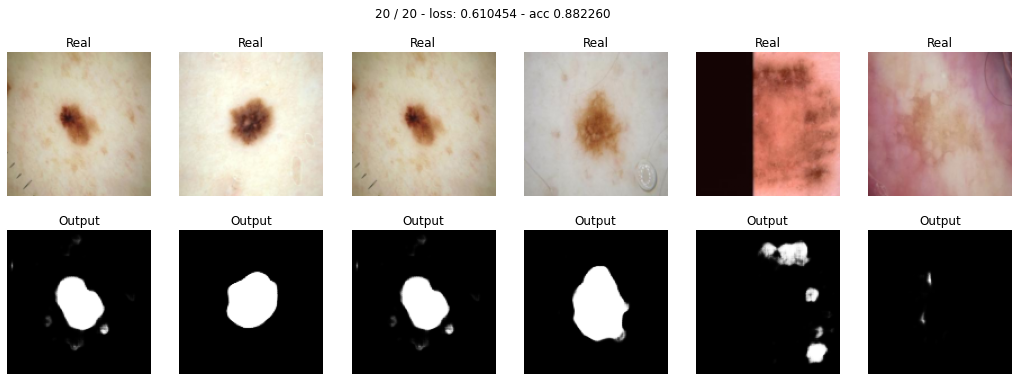

(0.8822603861490885,
 0.6104539632797241,
 0.8635660807291666,
 0.6207517981529236)

In [115]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, validation_loader)

## Test model with test set

In [116]:
size = 128
validation_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
testset = ISIC(data_path='/dtu/datasets1/02514/isic/test_style0', test=True, transform=validation_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

459


In [121]:
def evaluate(model, test_loader, loss_fn, vis=True):
    model.eval()  # testing mode
    test_loss = 0
    test_correct = 0
    batch_counter = 0
    for x_test, y_test in test_loader:
        batch_counter +=1
        x_test, y_test = x_test.to(device), y_test.to(device)
        with torch.no_grad():
            output, y_sigmoid = model(x_test)
            y_pred = torch.where(y_sigmoid > 0.5, 1., 0.)

        loss = loss_fn(y_test, y_sigmoid)
        test_loss += loss/len(test_loader)
        test_correct += (y_test==y_pred).sum().cpu().item()

        # keep some images from the first batch for visualizion
        if batch_counter == 1:
            y_test_ = copy.deepcopy(y_test)
            y_sigmoid_ = copy.deepcopy(y_sigmoid)

    test_accuracy = test_correct/(len(testset)*128*128)

    if vis:
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(y_test_.detach().cpu()[k, 0], cmap='gray')
            plt.title(f'seg #{k}')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(y_sigmoid_.detach().cpu().numpy()[k, 0], cmap='gray')
            plt.title(f'pred #{k}')
            plt.axis('off')

        plt.suptitle(f'Segmentations vs Predictions \nLoss: {test_loss} . Accuracy: {test_accuracy}')
        plt.show()

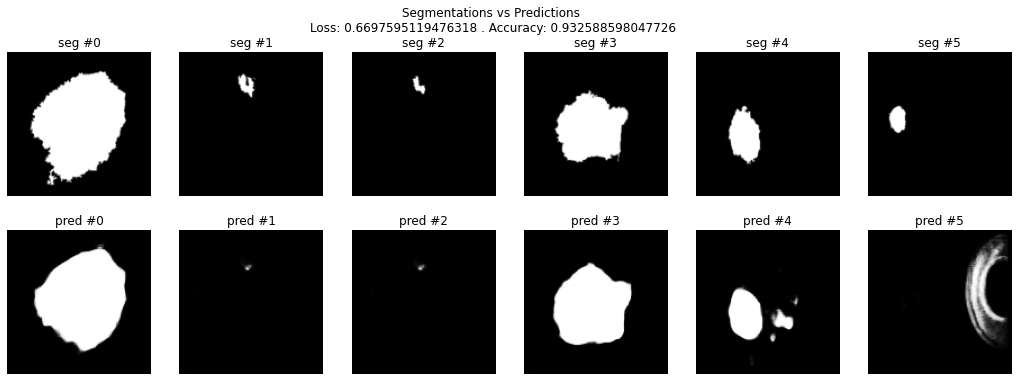

In [122]:
evaluate(model, test_loader, bce_loss)

In [ ]:
def predict(model, data, loss_fn, vis=False):
    X_test, Y_test = next(iter(data))

    model.eval()  # testing mode
    Y_test_pred, y_sigmoid = model(X_test.to(device))
    loss = loss_fn(Y_test.to(device), y_sigmoid)

    if vis:
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(Y_test[k, 0], cmap='gray')
            plt.title(f'seg #{k}')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(y_sigmoid.detach().cpu().numpy()[k, 0], cmap='gray')
            plt.title(f'pred #{k}')
            plt.axis('off')

        plt.suptitle('Segmentations vs Predictions')
        plt.show()

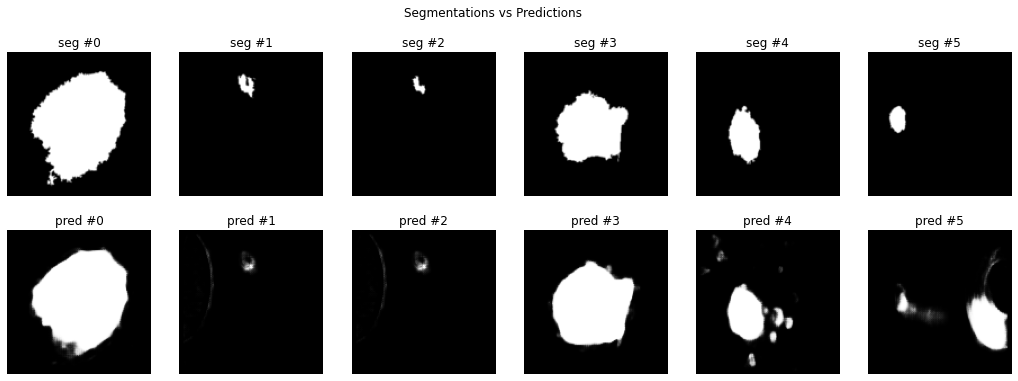

In [67]:
predict(model, test_loader, bce_loss, vis=True)

# Part 2

## New loss function

In [127]:
def dice_loss(y_real, y_pred):
    return torch.mean(1 - ((2.* y_real * y_pred + 1) / (y_real + y_pred + 1)))

## Data Augmentation

In [128]:
import torchvision.transforms.functional as TF
# from torchvision.transforms import Compose
from torchvision import transforms
import torch
import random
import numpy as np
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter

class GaussianNoise:
    """Apply Gaussian noise to tensor."""

    def __init__(self, mean=0., std=1., p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, tensor):
        noise = 0
        if random.random() < self.p:
            noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

class DoubleToTensor:
    """Apply horizontal flips to both image and segmentation mask."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask, weight=None):
        if weight is None:
            return TF.to_tensor(image), TF.to_tensor(mask)
        weight = weight.view(1, *weight.shape)
        return TF.to_tensor(image), TF.to_tensor(mask), weight

    def __repr__(self):
        return self.__class__.__name__ + '()'

class DoubleHorizontalFlip:
    """Apply horizontal flips to both image and segmentation mask."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask, weight=None):
        p = random.random()
        if p < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if weight is None:
            return image, mask
        elif p > self.p:
            weight = TF.hflip(weight)
        return image, mask, weight

    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p})'

class DoubleVerticalFlip:
    """Apply vertical flips to both image and segmentation mask."""

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask, weight=None):
        p = random.random()
        if p < self.p:
            image = TF.hflip(image)
            mask = TF.hflip(mask)
        if weight is None:
            return image, mask
        elif p > self.p:
            weight = TF.hflip(weight)
        return image, mask, weight

    def __repr__(self):
        return self.__class__.__name__ + f'(p={self.p})'

class DoubleElasticTransform:
    """Based on implimentation on
    https://gist.github.com/erniejunior/601cdf56d2b424757de5"""

    def __init__(self, alpha=250, sigma=10, p=0.5, seed=None, randinit=True):
        if not seed:
            seed = random.randint(1, 100)
        self.random_state = np.random.RandomState(seed)
        self.alpha = alpha
        self.sigma = sigma
        self.p = p
        self.randinit = randinit


    def __call__(self, image, mask, weight=None):
        if random.random() < self.p:
            if self.randinit:
                seed = random.randint(1, 100)
                self.random_state = np.random.RandomState(seed)
                self.alpha = random.uniform(100, 300)
                self.sigma = random.uniform(10, 15)
                # print(self.alpha)
                # print(self.sigma)

            dim = image.shape
            dx = self.alpha * gaussian_filter(
                (self.random_state.rand(*dim[1:]) * 2 - 1),
                self.sigma,
                mode="constant",
                cval=0
            )
            dy = self.alpha * gaussian_filter(
                (self.random_state.rand(*dim[1:]) * 2 - 1),
                self.sigma,
                mode="constant",
                cval=0
            )
            image = image.view(*dim[1:]).numpy()
            mask = mask.view(*dim[1:]).numpy()
            x, y = np.meshgrid(np.arange(dim[1]), np.arange(dim[2]))
            indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
            image = map_coordinates(image, indices, order=1)
            mask = map_coordinates(mask, indices, order=1)
            image, mask = image.reshape(dim), mask.reshape(dim)
            image, mask = torch.Tensor(image), torch.Tensor(mask)
            if weight is None:
                return image, mask
            weight = weight.view(*dim[1:]).numpy()
            weight = map_coordinates(weight, indices, order=1)
            weight = weight.reshape(dim)
            weight = torch.Tensor(weight)

        return (image, mask) if weight is None else (image, mask, weight)


class DoubleCompose(transforms.Compose):

    def __call__(self, image, mask, weight=None):
        if weight is None:
            for t in self.transforms:
                imageP = Image.fromarray(image)
                maskP = Image.fromarray(mask)
                image, mask = t(imageP, maskP)
            return image, mask
        for t in self.transforms:
            image, mask, weight = t(image, mask, weight)
        return image, mask, weight

## New dataloaders and train

In [129]:
DEBUG = False

size = 128
image_mask_transform = [
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor()]),                       
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor()]),  
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomRotation((-45, 45)), 
                        transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor()]),                      
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomVerticalFlip(), 
                        transforms.ToTensor()])
]

model_results = {
    'adam_bce': [],
    'sgd_bce': [],
    'adam_dice': [],
    'sgd_dice': []
    }
batch_size = 64

* Epoch 5/5
 - loss: 0.633550
 - train accuracy: 0.832599
 - val loss: 0.704228
 - val accuracy: 0.703153




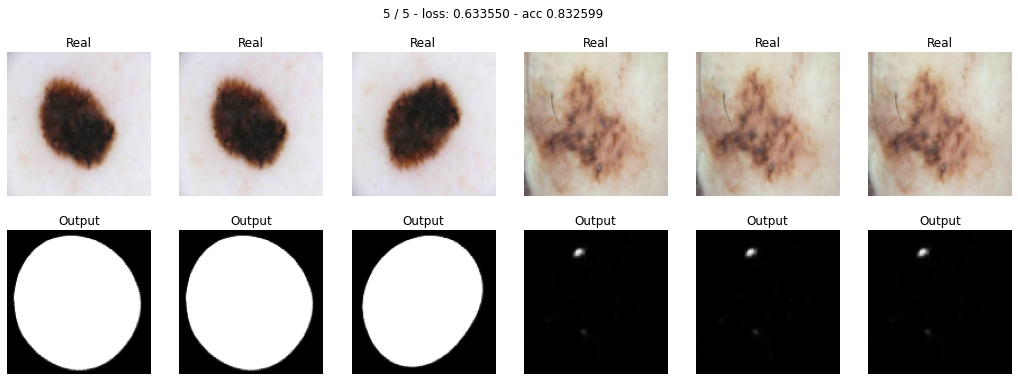

In [130]:
for trans in image_mask_transform:
    trainset = ISIC(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = ISIC(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
    model = UNet2(3, 1).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model_results['adam_bce'].append(train(model, optimizer, bce_loss,5,train_loader,test_loader))

* Epoch 5/5
 - loss: 0.076227
 - train accuracy: 0.834627
 - val loss: 0.174082
 - val accuracy: 0.641249




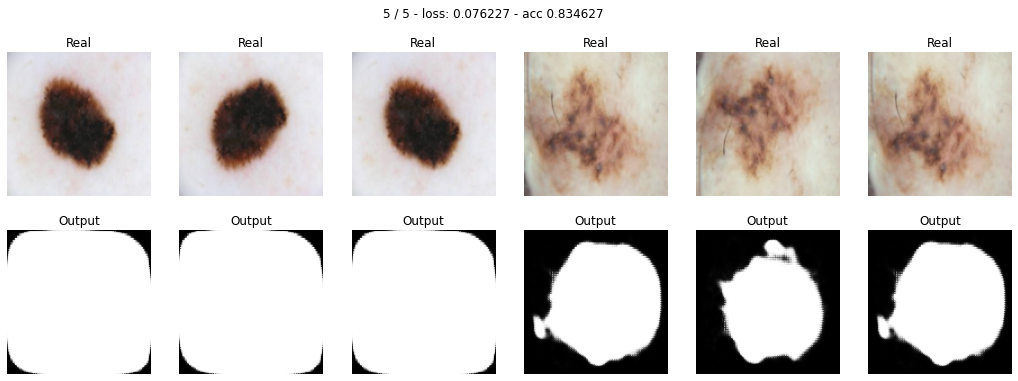

In [131]:
for trans in image_mask_transform:
    trainset = ISIC(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = ISIC(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
    model = UNet2(3, 1).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model_results['adam_dice'].append(train(model, optimizer, dice_loss,5,train_loader,test_loader))

In [158]:
model_results

{'adam_bce': [(0.8493927001953125,
   0.6253501176834106,
   0.7352305094401042,
   0.6984156370162964),
  (0.8352745056152344,
   0.631020188331604,
   0.6008046468098959,
   0.7731055617332458),
  (0.8198766072591146,
   0.6407079696655273,
   0.7129496256510417,
   0.6849109530448914),
  (0.6061935424804688,
   0.6645970344543457,
   0.55933837890625,
   0.7085993885993958),
  (0.832598876953125,
   0.6335501670837402,
   0.7031534830729167,
   0.7042278051376343)],
 'sgd_bce': [(0.8463818868001302,
   0.6326899528503418,
   0.6545267740885417,
   0.6955950260162354),
  (0.786474100748698,
   0.6572060585021973,
   0.6866750081380208,
   0.7057501673698425),
  (0.8181940714518229,
   0.6461790204048157,
   0.6684010823567709,
   0.7074848413467407),
  (0.6056844075520833,
   0.6614065766334534,
   0.44944864908854165,
   0.6811522245407104),
  (0.8239860534667969,
   0.640255868434906,
   0.6633514404296875,
   0.6952881813049316)],
 'adam_dice': [(0.8667661031087239,
   0.059181988

* Epoch 5/5
 - loss: 0.640256
 - train accuracy: 0.823986
 - val loss: 0.695288
 - val accuracy: 0.663351




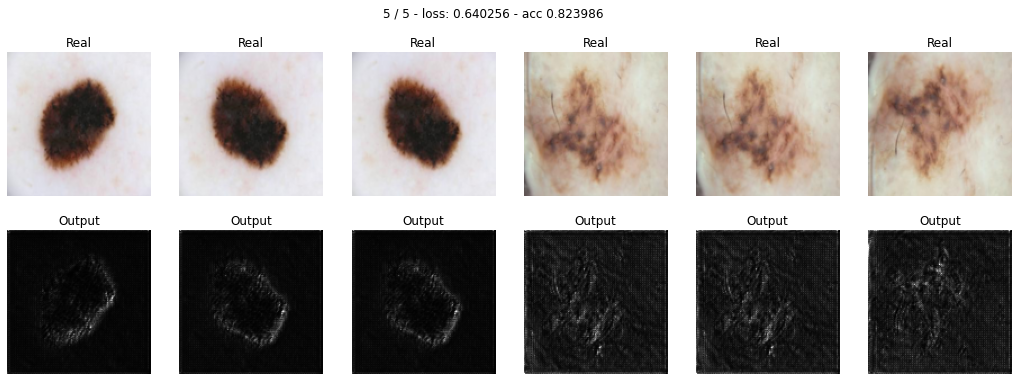

In [132]:

for trans in image_mask_transform:
    trainset = ISIC(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = ISIC(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
    model = UNet2(3, 1).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    model_results['sgd_bce'].append(train(model, optimizer, bce_loss,5,train_loader,test_loader))

* Epoch 5/5
 - loss: 0.085779
 - train accuracy: 0.823227
 - val loss: 0.164164
 - val accuracy: 0.663086




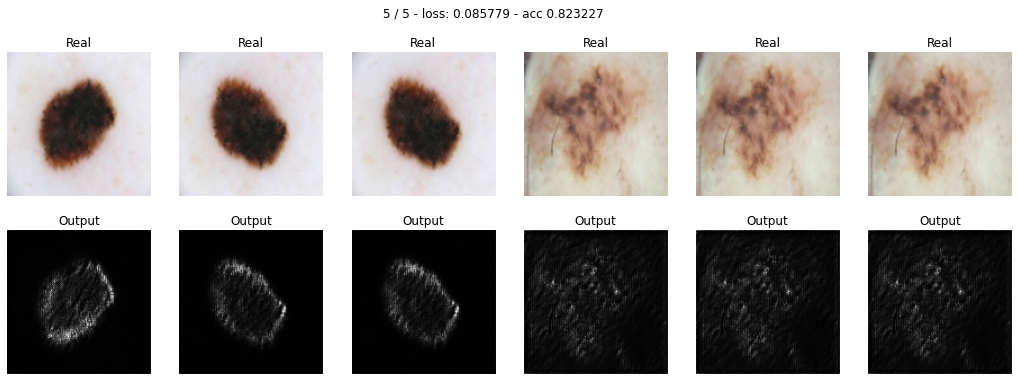

In [133]:
for trans in image_mask_transform:
    trainset = ISIC(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = ISIC(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)
    model = UNet2(3, 1).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    model_results['sgd_dice'].append(train(model, optimizer, dice_loss,5,train_loader,test_loader))

## Predict

In [157]:
num_epochs = 5
num_transformations = len(image_mask_transform)

In [148]:
loss_list = []
epoch_list = []
for model_id in range(num_epochs):
    sgd_bce_acc = model_results['sgd_bce'][model_id][2]
    adam_bce_acc = model_results['adam_bce'][model_id][2]
    sgd_dice_acc = model_results['sgd_dice'][model_id][2]
    adam_dice_acc = model_results['adam_dice'][model_id][2]

    sgd_bce_loss = model_results['sgd_bce'][model_id][3]
    adam_bce_loss = model_results['adam_bce'][model_id][3]
    sgd_dice_loss = model_results['sgd_dice'][model_id][3]
    adam_dice_loss = model_results['adam_dice'][model_id][3]

    # all the losses of this specific transformation
    transform_loss_list = [sgd_bce_loss, adam_bce_loss, sgd_dice_loss, adam_dice_loss]
    transform_acc_list = [sgd_bce_acc, adam_bce_acc, sgd_dice_acc, adam_dice_acc]
    # min loss of this transformation
    minloss = min(transform_loss_list)
    # keep which optimizer+loss had the best loss
    minid = np.argmin(transform_loss_list)
    loss_list.append([minloss, minid, transform_acc_list[minid]])

# keep the best loss
loss_list = np.array(loss_list)
transform_minloss = min(loss_list[:,0])
best_loss = transform_minloss
# find best transformation
best_transform_id = np.argmin(loss_list[:,0])
# find the best optimizer
best_optim_id = loss_list[best_transform_id, 1]
accuracy = loss_list[best_transform_id, 2]

if best_optim_id == 0:
    best_optim = "sgd"
    best_loss_fn = "bce"
elif best_optim_id == 1:
    best_optim = "adam"
    best_loss_fn = "bce"
elif best_optim_id == 2:
    best_optim = "sgd"
    best_loss_fn = "dice"
else:
    best_optim = "adam"
    best_loss_fn = "dice"

print('best model optimizer :', best_optim)
print('best model loss:', best_loss_fn)
print('loss:', best_loss)
print('accuracy:', accuracy)
print(f"transformation id: {best_transform_id} (only resize)")


best model optimizer : adam
best model loss: dice
loss: 0.10854370892047882
accuracy: 0.7741017659505208
transformation id: 0 (only resize)


In [ ]:
sgd_bce = model_results['sgd_bce']

In [155]:
model_results

{'adam_bce': [(0.8493927001953125,
   0.6253501176834106,
   0.7352305094401042,
   0.6984156370162964),
  (0.8352745056152344,
   0.631020188331604,
   0.6008046468098959,
   0.7731055617332458),
  (0.8198766072591146,
   0.6407079696655273,
   0.7129496256510417,
   0.6849109530448914),
  (0.6061935424804688,
   0.6645970344543457,
   0.55933837890625,
   0.7085993885993958),
  (0.832598876953125,
   0.6335501670837402,
   0.7031534830729167,
   0.7042278051376343)],
 'sgd_bce': [(0.8463818868001302,
   0.6326899528503418,
   0.6545267740885417,
   0.6955950260162354),
  (0.786474100748698,
   0.6572060585021973,
   0.6866750081380208,
   0.7057501673698425),
  (0.8181940714518229,
   0.6461790204048157,
   0.6684010823567709,
   0.7074848413467407),
  (0.6056844075520833,
   0.6614065766334534,
   0.44944864908854165,
   0.6811522245407104),
  (0.8239860534667969,
   0.640255868434906,
   0.6633514404296875,
   0.6952881813049316)],
 'adam_dice': [(0.8667661031087239,
   0.059181988

In [149]:
sgd_bce_results = [[x, y] for [x,y,z,w] in model_results['sgd_bce']]
adam_bce_results = [[x, y] for [x,y,z,w] in model_results['adam_bce']]
sgd_dice_results = [[x, y] for [x,y,z,w] in model_results['sgd_dice']]
adam_dice_results = [[x, y] for [x,y,z,w] in model_results['adam_dice']]

In [ ]:
fig, ax = plt.subplots()

num_epochs = len(sgd_bce_results)
ax.plot([y for [x,y] in sgd_bce_results], color='red', linestyle='dashed', linewidth=2)
ax.plot([y for [x,y] in adam_bce_results], color='blue', linestyle='dashed', linewidth=2)
ax.plot([y for [x,y] in sgd_dice_results], color='red', linewidth=2)
ax.plot([y for [x,y] in adam_dice_results], color='blue', linewidth=2)

plt.legend(('Test accuracy SGG + bce','Test accuracy ADAM + bce','Train accuracy SGG + dice','Train accuracy ADAM + dice'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()